# Dashboard Widgets
In this module, we will use ipywidgets to turn our workflow into a data dashboard. To achieve this, we have several substeps to accomplish. Some are the same as the original workflow. New steps are bolded.

In [ ]:
#| default_exp widgets

1. Load data from file
2. Use a slider widget to select and display selected range of years
  - Use the slider value to update the `selected` data
  - Update the `selected` data *every time* the range is modified
4. Update selected dataframe with new range


We will learn how to...

1. Import ipywidgets
2. Set trait values
3. Observe trait changes
4. Unobserve trait changes
5. Display things with output widgets
6. Use container widgets to create layouts

### Import ipywidgets
Let's add an import statement for ipywidgets. We will use a lot of widgets, so it's good to import ipywidgets as widgets, or something similiarly short. Add an import statement below and then go to [ipywidgets documentation site](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html) to get a sense of what kind of widgets there are.

In [ ]:
#| export
import pandas as pd
import os
import ipywidgets as widgets # add import statement
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter

In [ ]:
# %load -r 8-11 dashboard/dashboard.py
# %% ../03_dashboarding.ipynb 3
import pandas as pd
import os
import ipywidgets as widgets # add import statement

In [ ]:
%load?

Docstring:
Load code into the current frontend.

Usage:
  %load [options] source

  where source can be a filename, URL, input history range, macro, or
  element in the user namespace

If no arguments are given, loads the history of this session up to this
point.

Options:

  -r <lines>: Specify lines or ranges of lines to load from the source.
  Ranges could be specified as x-y (x..y) or in python-style x:y 
  (x..(y-1)). Both limits x and y can be left blank (meaning the 
  beginning and end of the file, respectively).

  -s <symbols>: Specify function or classes to load from python source. 

  -y : Don't ask confirmation for loading source above 200 000 characters.

  -n : Include the user's namespace when searching for source code.

This magic command can either take a local filename, a URL, an history
range (see %history) or a macro as argument, it will prompt for
confirmation before loading source with more than 200 000 characters, unless
-y flag is passed or if the frontend does

## Load Data from File

Now we will load the data, just like last time.

In [ ]:
#| export
# Load data into memory from file
DATA_DIR = 'data'
DATA_FILE = 'land-ocean-temp-index.csv'

original_data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE), escapechar='#')
original_data

,Year,Temperature
0,1880,-0.15
1,1881,-0.07
2,1882,-0.09
3,1883,-0.16
4,1884,-0.27
...,...,...
135,2015,0.90
136,2016,1.02
137,2017,0.93
138,2018,0.86


## Goal: Use a slider widget to select and display selected range of years

Okay. Now we want to select the data and also update the display of the dataframe. To do this, we will use our first ipywidget. Because we are selecting a range of years, we will use the `IntRangeSlider` widget, which has two click and drag nobs. Let's see what that looks like and play around with the click-and-drag functionality.

In [ ]:
#| export
year_range = widgets.IntRangeSlider(description = 'Range of Years')
year_range

IntRangeSlider(value=(25, 75), description='Range of Years')

Okay great! Plat But 0 - 100 isn't the range we want. Instead, we would like the minimum and maximum to be the earliest and latest years in our dataset. So we need to obtain those first. 

In [ ]:
(min(original_data['Year']), max(original_data['Year']))

(1880, 2019)

### Set Trait Values

That looks right. Let's use the same syntax to set the min and max of the slider widget.

In [ ]:
#| export
year_range.max =  max(original_data['Year'])  # set the 'max' attribute of the slider to the minimum year of the our data  
year_range.min = min(original_data['Year'])  # and let's do the same for 'min'

Okay that looks a lot better, but how to we actually get the value of the range from the widget? Generally, most widgets have a `value` attribute, but since there are actually two values in a range, I'm not sure what to expect. Let's see what happens when we try and poll the value attribute. What data type is it?

In [ ]:
year_range.value

(1880, 1880)

That looks like a tuple. Let's try setting the value programmatically as well.

In [ ]:
year_range.value = (1900, 2000)

Okay, now that we can get the range from the slider, how do we relect those selections back to the dataframe? 

## Use the slider value to update the `selected` data
Well, we probably want to keep two copies, because if we change the original to have a shorter range, and then we want to expand that range, we're going to have lost data. So let's maintain a dataframe called `selected` that reflects the range specified by the Slider. Let's look at how we did that in workflow.ipynb. 

```python
selected = original_data[(original_data['Year'] >= from_year) & (original_data['Year'] <= to_year)]
```

The only difference is this time, we need to replace "from_year" and "to_year" with the value of our slider. Try that on your own in the cells below.

In [ ]:
#| export
selected = original_data[(original_data['Year'] >= year_range.value[0]) & (original_data['Year'] <= year_range.value[1])] # selected = original_data[(original_data['Year'] >= from_year) & (original_data['Year'] <= to_year)]

In [ ]:
selected

,Year,Temperature
20,1900,-0.07
21,1901,-0.15
22,1902,-0.27
23,1903,-0.36
24,1904,-0.46
...,...,...
116,1996,0.33
117,1997,0.46
118,1998,0.61
119,1999,0.39


Okay, that's a start. But now we want to do this dynamically. That is, we want the line above to be called every time the range is modified. 

## Update the `selected` data *every time* the range is modified

How do we track changes to the value of the slider?

### Observing trait changes

Widgets are built on the `traitlets` library, which we will learn more about later on. Attributes of objects that inherit the `HasTraits` class, such as widgets do, are called traits. Any trait can be "observed" for changes. This means we can observe the "value" trait of the slider for changes.

In [ ]:
def on_range_change(change):
    print(change)

In [ ]:
year_range.observe(on_range_change, 'value')

So if we change the value of the slider, our observe function will print the `change`. But what type of data is `change`? Let's find out by changing the value of the slider programmatically.

In [ ]:
year_range.value = (1880, 2000)

{'name': 'value', 'old': (1900, 2000), 'new': (1880, 2000), 'owner': IntRangeSlider(value=(1880, 2000), description='Range of Years', max=2019, min=1880), 'type': 'change'}


So there are a lot of things going on here. Now we know that `change` is a dictionary. There are a lot of key/value pairs here, but the most important one's for us right now are the "old" and "new" keys. We can use them to see what the value trait used to be, and what it was updated to. 

## Update `selected` dataframe with new range
Now that we know how to observe changes in the slider value, we want to use that observe function to update the `selected` dataframe. Let's rewrite the `on_range_change` function so that it updates the `selected` dataframe.

In [ ]:
#| export
def on_range_change(change):
    global selected
    selected = original_data[(original_data['Year'] >= change['new'][0]) & (original_data['Year'] <= change['new'][1])]

In [ ]:
year_range.observe(on_range_change, 'value')

In [ ]:
year_range.value = (1990, 1993)

{'name': 'value', 'old': (1880, 2000), 'new': (1990, 1993), 'owner': IntRangeSlider(value=(1990, 1993), description='Range of Years', max=2019, min=1880), 'type': 'change'}


In [ ]:
selected

,Year,Temperature
110,1990,0.45
111,1991,0.41
112,1992,0.22
113,1993,0.23


That worked really well! But we are still printing the change. I thought we redefined the function! As it turns out, both versions of the function have copies that are called when there is a change. 

### Unobserve trait changes

To get rid of all those observe functions, we use the `unobserve_all` method. Go ahead and try that.

In [ ]:
year_range.unobserve_all()

In [ ]:
year_range.observe(on_range_change)
year_range.value = (1993, 1996)

Hmmmm.... it seems that we've gotten an error. Sort of a weird one. I think we are missing something on our observe call. Can you think of what it is? I think it has something to do with the `observe()` parameters. Go ahead and make the changes needed below.

In [ ]:
year_range.unobserve_all()

In [ ]:
#| export
year_range.observe(on_range_change, 'value') # year_range.observe(on_range_change)

In [ ]:
year_range.value = (1996, 1999)

Does it run like it's supposed to now? Great! Now that we have that down, the next step is to update the dataframe display every time the range is changed. But how do we achieve that? The dataframe isn't actually a widget yet. It's just being displayed with ipython. But we can turn anything that can be displayed with ipython into a widget with Output.

## Output widgets

First, let's see what output looks like on it's own.

In [ ]:
#| export
selected_data_output = widgets.Output()
selected_data_output

Output()

Pretty boring. **Let's right click on the Output widget and "Create new view for output"** for now. How do we get it to display our dataframe? We use the Output widget as a context manager. Anything that we can display with ipython.display can be displayed by the Output widget using the following syntax.

In [ ]:
with selected_data_output:
    display(original_data)

Voila! The selected_data_output widget now displays the dataframe. Now we need to be able to update that display in case someone changes the range. Let's write a function for this.

In [ ]:
#| export
def display_selected_data(change): 
    selected_data_output.clear_output(wait=True)
    with selected_data_output: 
        display(selected)

In [ ]:
#| export
display_selected_data(None)

Cool! Now the only thing that is missing is that we want to call this function every time the range is updated. How might we go about that?

Well, we could use another observe function! Let's try it.

In [ ]:
#| export
year_range.observe(display_selected_data, 'value')

Okay let's create another copy of the slider so we can change the value that way. Then go ahead and move the range around. 

In [ ]:
year_range

IntRangeSlider(value=(1996, 1999), max=2019, min=1880)

Way cool. Now our dataframe reflects the range of values.

## Add column for Savitzky-Golay filter

Now we have data selection down, so the next step is to also add a column to our data for the smoothed curve. Let's review what we had in the workflow. Keep in mind that we will be working with `original_data` instead of `selected` for a while.

In [ ]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 20
poly_order = 3

In [ ]:
# Apply Savitzky-Golay smoothing to the Temperature column
original_data['Savitzky-Golay'] = savgol_filter(original_data['Temperature'], window_size, poly_order)
original_data

,Year,Temperature,Savitzky-Golay
0,1880,-0.15,-0.080608
1,1881,-0.07,-0.127233
2,1882,-0.09,-0.165917
3,1883,-0.16,-0.197239
4,1884,-0.27,-0.221776
...,...,...,...
135,2015,0.90,0.803389
136,2016,1.02,0.845991
137,2017,0.93,0.896738
138,2018,0.86,0.956597


Okay. So we have these two variables that we want to turn into sliders. Let's make the Sliders first.

In [ ]:
#| export
window_size = widgets.IntSlider(description = 'Window Size', min=1, max=100)

In [ ]:
window_size

IntSlider(value=1, description='Window Size', min=1)

In [ ]:
#| export
poly_order = widgets.BoundedIntText(description = 'Poly Order', min=0, max=10)

In [ ]:
poly_order

IntSlider(value=0, description='Poly Order', max=10)

Now when we update window size, we want a few things to happen. 

1. Update original_data
2. Use original_data to update selected
3. Update display of selected

Let's write a function that takes care of the first two.

In [ ]:
#| export
def on_window_size_change(change):
    global original_data, selected
    original_data['Savitzky-Golay'] = savgol_filter(original_data['Temperature'], change['new'], poly_order.value) # original_data['Savitzky-Golay'] = savgol_filter(original_data['Temperature'], window_size, poly_order)
    selected = original_data[(original_data['Year'] >= year_range.value[0]) & (original_data['Year'] <= year_range.value[1])]

Then do you recall what function we used to display the dataframe? It was `display_selected_data`. Let's make sure we add both to the functions observed by window_size.

In [ ]:
#| export
window_size.observe(on_window_size_change, 'value')
window_size.observe(display_selected_data, 'value')

In [ ]:
window_size

IntSlider(value=1, description='Window Size', min=1)

Sweet! If you still have an Output View of the `selected` dataframe open, and you increase the value of `window_size` you will see that there is now a Savitzky-Golay column. Now I want you to create a Slider widget that is linked to the `poly_order`. 

In [ ]:
#| export
def on_poly_order_change(change):
    global original_data, selected
    original_data['Savitzky-Golay'] = savgol_filter(original_data['Temperature'], window_size.value, change['new']) # original_data['Savitzky-Golay'] = savgol_filter(original_data['Temperature'], window_size, poly_order)
    selected = original_data[(original_data['Year'] >= year_range.value[0]) & (original_data['Year'] <= year_range.value[1])]

In [ ]:
#| export
poly_order.observe(on_poly_order_change, 'value')
poly_order.observe(display_selected_data, 'value')

In [ ]:
poly_order

IntSlider(value=0, description='Poly Order', max=10)

That looks pretty good! Let's try setting both values programmatically.

In [ ]:
window_size.value = 3
poly_order.value = 4

Uh oh. Why did this happen? Fortunately the error message is pretty clear. We need to ensure that our poly_order Slider doesn't allow a user to select a value greater than `window_length - 1`. But we also don't want to let poly_order be greater than 10 to avoid poor conditioning. Where should we put this validation? Well, we are going to need to update the "max" trait of `poly_order` every time `window_length` is updated. So we need to add a line to add a line in the `on_window_length_change` funciton.

In [ ]:
#| export
def on_window_size_change(change):
    global original_data, selected, poly_order
    # change the maximum of the poly_order widget
    original_data['Savitzky-Golay'] = savgol_filter(original_data['Temperature'], change['new'], poly_order.value)
    selected = original_data[(original_data['Year'] >= year_range.value[0]) & (original_data['Year'] <= year_range.value[1])]


In [ ]:
window_size.unobserve_all()

In [ ]:
#| export
window_size.observe(on_window_size_change, 'value')
window_size.observe(display_selected_data, 'value')

In [ ]:
window_size

IntSlider(value=3, description='Window Size', min=1)

In [ ]:
poly_order

IntSlider(value=4, description='Poly Order', max=10)

In [ ]:
#| export
window_size.value = 10
poly_order.value = 1

Amazing! We are doone visualizing our selected data. Now we can move on to visualizing our data with a plot.

## Visualizing Data

We will use matplotlib, because the syntax is so common, but there are more interactive widgets in the ipywidget ecosystem that would work even better, such as bqplot.

Before we get started, let's take a look at what we had in the original workflow.

```python
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.plot(selected_range['Year'], selected_range['Temperature'])
plt.plot(selected_range['Year'], selected_range['Savitzky-Golay']) 
plt.show()
```

We are going to want to turn this into an observe function that accepts a "change" parameter. Is there anything we need to fix here to make this work? It's very minor. Edit the code chunk below so that it works in our current notebook. 

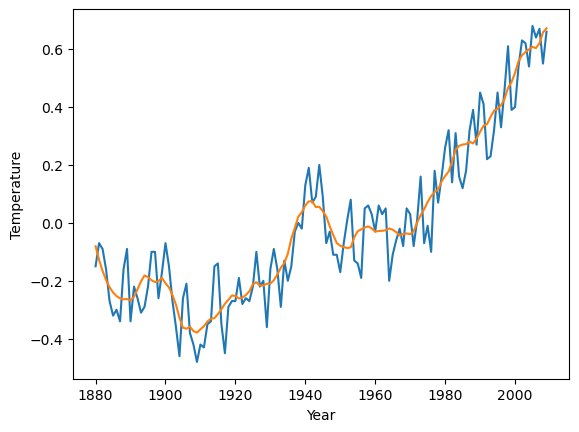

In [ ]:
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.plot(selected['Year'], selected['Temperature'])  # plt.plot(selected_range['Year'], selected_range['Temperature'])
plt.plot(selected['Year'], selected['Savitzky-Golay']) 
plt.show()

Okay that works, but the plot is showing up in the log, and we want to show it in our notebook. What can we do to show and update the plot displayed in the notebook?

Yeah, we can use an Output widget again, just like we did with the dataframe.

In [ ]:
#| export
plot_output = widgets.Output() # create an output widget called selected_data_output
plot_output

Output()

Go ahead and create an Output View for this widget also.

Okay. Now let's remember what we did to update our display last time. 
```python
def display_selected_data(change): 
    selected_data_output.clear_output(wait=True)
    with selected_data_output: 
        display(selected)
```

Go ahead and adapt this function so that instead of displaying the selected dataframe, it displays an updated plot.

In [ ]:
#| export
def display_plot(change):  # def display_selected_data(change): 
    plot_output.clear_output(wait=True) #selected_data_output.clear_output(wait=True)
    with plot_output:  # with selected_data_output: 
        plt.xlabel('Year') # display(selected)
        plt.ylabel('Temperature') 
        plt.plot(selected['Year'], selected['Temperature'])  # plt.plot(selected_range['Year'], selected_range['Temperature'])
        plt.plot(selected['Year'], selected['Savitzky-Golay']) 
        plt.show() 

Let's make sure out new callback works when we call it explicitly.

In [ ]:
display_plot(None)

Now let's make sure this function gets called any time there is a change to our selected data or to the Savitzky-Golay parameters. How do we make sure this function runs every time there is a change?

In [ ]:
#| export
year_range.observe(display_plot, 'value')
window_size.observe(display_plot, 'value')
poly_order.observe(display_plot, 'value')

In [ ]:
#| export
year_range.value = (1900, 2000)

In [ ]:
year_range

IntRangeSlider(value=(1880, 1966), max=2019, min=1880)

In [ ]:
window_size

IntSlider(value=21, description='Window Size', min=1)

In [ ]:
poly_order

IntSlider(value=4, description='Poly Order', max=10)

Wow that looks amazing! We have a total of five widgets. Three of them control various parameters and they have dependencies on each other. In the next notebook, we will see how this can all come together into one very beautiful interface.

In [ ]:
from nbdev.export import nb_export
nb_export('03_dashboarding.ipynb', 'dashboard')
nb_export('03_dashboarding.ipynb', '.dashboard_key')